In [5]:
'''Example script to generate text from Nietzsche's writings.

At least 20 epochs are required before the generated text
starts sounding coherent.

It is recommended to run this script on GPU, as recurrent
networks are quite computationally intensive.

If you try this script on new data, make sure your corpus
has at least ~100k characters. ~1M is better.
'''

from __future__ import print_function
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.layers import LSTM
from keras.utils.data_utils import get_file
import numpy as np
import random
import sys

path = get_file('nietzsche.txt', origin="https://s3.amazonaws.com/text-datasets/nietzsche.txt")
text = open(path).read().lower()
print('corpus length:', len(text))

chars = sorted(list(set(text)))
print('total chars:', len(chars))
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))

# cut the text in semi-redundant sequences of maxlen characters
maxlen = 40
step = 3
sentences = []
next_chars = []
for i in range(0, len(text) - maxlen, step):
    sentences.append(text[i: i + maxlen])
    next_chars.append(text[i + maxlen])
print('nb sequences:', len(sentences))

print('Vectorization...')
X = np.zeros((len(sentences), maxlen, len(chars)), dtype=np.bool)
y = np.zeros((len(sentences), len(chars)), dtype=np.bool)
for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        X[i, t, char_indices[char]] = 1
    y[i, char_indices[next_chars[i]]] = 1


# build the model: 2 stacked LSTM
print('Build model...')
model = Sequential()
model.add(LSTM(512, return_sequences=True, input_shape=(maxlen, len(chars))))
model.add(LSTM(512, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(len(chars)))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy', optimizer='rmsprop')

def sample(a, temperature=1.0):
    # helper function to sample an index from a probability array
    a = np.log(a) / temperature
    a = np.exp(a) / np.sum(np.exp(a))
    return np.argmax(np.random.multinomial(1, a, 1))


Using TensorFlow backend.


corpus length: 600901
total chars: 59
nb sequences: 200287
Vectorization...
Build model...


In [ ]:

# train the model, output generated text after each iteration
for iteration in range(1, 60):
    print()
    print('-' * 50)
    print('Iteration', iteration)
    model.fit(X, y, batch_size=128, nb_epoch=1)

    start_index = random.randint(0, len(text) - maxlen - 1)

    for diversity in [0.2, 0.5, 1.0, 1.2]:
        print()
        print('----- diversity:', diversity)

        generated = ''
        sentence = text[start_index: start_index + maxlen]
        generated += sentence
        print('----- Generating with seed: "' + sentence + '"')
        sys.stdout.write(generated)

        for i in range(400):
            x = np.zeros((1, maxlen, len(chars)))
            for t, char in enumerate(sentence):
                x[0, t, char_indices[char]] = 1.

            preds = model.predict(x, verbose=0)[0]
            next_index = sample(preds, diversity)
            next_char = indices_char[next_index]

            generated += next_char
            sentence = sentence[1:] + next_char

            sys.stdout.write(next_char)
            sys.stdout.flush()
        print()

In [ ]:
from io import StringIO
import sys

class Hider:
    def __init__(self, channels=('stdout',)):
        self._stomach = StringIO()
        self._orig = {ch : None for ch in channels}

    def __enter__(self):
        for ch in self._orig:
            self._orig[ch] = getattr(sys, ch)
            setattr(sys, ch, self)
        return self

    def write(self, string):
        self._stomach.write(string)

    def flush(self):
        pass

    def autopsy(self):
        return self._stomach.getvalue()

    def __exit__(self, *args):
        for ch in self._orig:
            setattr(sys, ch, self._orig[ch])

In [16]:
%matplotlib inline
from __future__ import print_function
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.layers import LSTM
from keras.layers.core import Reshape
from keras.utils.data_utils import get_file
import numpy as np
import random
import sys

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from data_interpreter_Keras import dataInterpreter, metaDataEndomondo
from inputManager import inputManager
import matplotlib
#matplotlib.use('agg')
import matplotlib.pyplot as plt

zMultiple = 5

data_path = "../multimodalDBM/endomondoHR_proper_copy.json"
summaries_dir = "logs"
#endoFeatures = ["sport", "heart_rate", "gender", "altitude", "time_elapsed", "distance", "new_workout", "derived_speed", "userId"]
endoFeatures = ["sport", "heart_rate", "gender", "altitude", "time_elapsed", "distance", "new_workout", "derived_speed"]
trainValTestSplit = [0.8, 0.1, 0.1]
targetAtt = "heart_rate"
inputOrderNames = [x for x in endoFeatures if x!=targetAtt]
trimmed_workout_len = 450
num_steps = 128
batch_size_m = 64


endo_reader = dataInterpreter(fn=data_path, scaleVals=True, trimmed_workout_length=trimmed_workout_len)
endo_reader.buildDataSchema(endoFeatures, targetAtt, trainValTestSplit, zMultiple)
input_dim = endo_reader.getInputDim(targetAtt)
target_dim = endo_reader.getTargetDim(targetAtt)

num_samples = int((trimmed_workout_len*endo_reader.numDataPoints))

print('Build model...')
model = Sequential()
#model.add(Reshape((batch_size_m, num_steps, input_dim), batch_input_shape=(batch_size_m*num_steps, input_dim)))
model.add(LSTM(128, return_sequences=True, batch_input_shape=(batch_size_m, num_steps, input_dim), stateful=True))
model.add(Dropout(0.2))
model.add(LSTM(128, return_sequences=True, stateful=True))
model.add(Dropout(0.2))
model.add(Dense(target_dim))
model.add(Activation('linear'))

model.compile(loss='mean_squared_error', optimizer='rmsprop')
print("Endomodel Built!")

Loading metadata
Metadata loaded
Number of data points: 180656
Build model...
Endomodel Built!


In [17]:
epoch_train_scores = []
epoch_valid_scores = []
for iteration in range(1, 60):
    print()
    print('-' * 50)
    print('Iteration', iteration)
    trainDataGen = endo_reader.endoIteratorSupervised(batch_size_m, num_steps, "train")  # A generator over the endomondo data
    train_losses = []
    running_mean=0
    count=0
    print("Training")
    #fit_generator(dataGen, num_samples, 1)
    total_gen_runs = (num_samples*trainValTestSplit[0])/(num_steps*batch_size_m)
    num_generator_runs = 0
    for X, y in trainDataGen:
        #input_data = np.reshape(X, (batch_size_m, num_steps, input_dim), order='C')
        #target_data = np.reshape(y, (batch_size_m, num_steps, target_dim), order='C')
        #model.fit(input_data, target_data, batch_size=batch_size_m, nb_epoch=1)
        #model.fit(X, y, batch_size=batch_size_m, nb_epoch=1)
        batch_loss = model.train_on_batch(X,y)
        train_losses.append(batch_loss)
        #print("-", end='')
        
        num_generator_runs+=1
        fraction_complete = num_generator_runs/total_gen_runs
        print("\r", end='')
        count+=1
        running_mean = (running_mean*(count-1)+batch_loss)/count
        print("Current batch loss: " + str(batch_loss) + "    average loss for current epoch: " + str(running_mean) + "    {0:.3f} complete".format(fraction_complete), end='')
        #print("\033[F]")
    #print("num generator runs: ", num_generator_runs)
    epoch_train_loss = np.mean(train_losses)
    print("\nTraining loss: " + str(epoch_train_loss))
    epoch_train_scores.append(epoch_train_loss)
    
    validDataGen = endo_reader.endoIteratorSupervised(batch_size_m, num_steps, "valid")
    valid_losses = []
    print("Validating")
    #evaluate_generator(dataGen, num_samples, 1)
    for X, y in validDataGen:
        batch_loss = model.test_on_batch(X, y)
        valid_losses.append(batch_loss)
        print("-", end='')
        num_generator_runs+=1
        #print("Current batch loss: " + str(batch_loss) + "    average loss for current epoch: " + str(np.mean(valid_losses)), end='\n')
    epoch_valid_loss = np.mean(valid_losses)
    print("num generator runs: ", num_generator_runs)
    print("\nValidation loss: " + str(epoch_valid_loss))
    epoch_valid_scores.append(np.mean(valid_losses))
        
    
    
    #start_index = random.randint(0, len(text) - maxlen - 1)
    """
    for diversity in [0.2, 0.5, 1.0, 1.2]:
        print()
        print('----- diversity:', diversity)
        
        testDataGen = endo_reader.endoIteratorSupervised(batch_size_m, num_steps, trainValidTest)  # A generator over the endomondo data
        X, y = testDataGen.next()
        generated = ''
        sentence = text[start_index: start_index + maxlen]
        generated += sentence
        print('----- Generating with seed: "' + sentence + '"')
        sys.stdout.write(generated)

        for i in range(400):
            x = np.zeros((1, maxlen, len(chars)))
            for t, char in enumerate(sentence):
                x[0, t, char_indices[char]] = 1.

            preds = model.predict(x, verbose=0)[0]
            next_index = sample(preds, diversity)
            next_char = indices_char[next_index]

            generated += next_char
            sentence = sentence[1:] + next_char

            sys.stdout.write(next_char)
            sys.stdout.flush()
        print()
        """


--------------------------------------------------
Iteration 1
Training
Current batch loss: 4.81103    average loss for current epoch: 16.7177861532    0.000 complete

KeyboardInterrupt: 

In [ ]:
#Get a data point for plotting the progress
pred_gen = endo_reader.endoIteratorSupervised(batch_size_m, num_steps, "test")
prediction_inputs = []
prediction_targets = []
for i in range(trimmed_workout_len):
    timestep = pred_gen.next()
    prediction_inputs.append(timestep[0])
    prediction_targets.append(timestep[1])

for iteration in range(1, 60):
    print()
    print('-' * 50)
    print('Iteration', iteration)
    trainDataGen = endo_reader.generator_for_autotrain(batch_size_m, num_steps, "train")  # A generator over the endomondo data
    print("Training")
    fit_generator(trainDataGen, int(num_samples*trainValTestSplit[0]), 1)
    
    validDataGen = endo_reader.generator_for_autotrain(batch_size_m, num_steps, "valid")
    
    #fit_generator(trainDataGen, int(num_samples*trainValTestSplit[0]), 1, validation_data=validDataGen, nb_val_samples = int(num_samples*trainValTestSplit[0]), nb_worker=)
    
    print("Validating")
    evaluate_generator(dataGen, int(num_samples*trainValTestSplit[1]), 1)
    
    print("Predicting")
    predictions = model.predict_on_batch(prediction_inputs)
    #Now plot the predictions vs the targets...
    indices=np.array(range(len(predictions)))
    plt.figure(num=None, figsize=(15, 10), dpi=100, facecolor='w', edgecolor='k')
    plt.plot(indices, predictions, 'r--', indices, prediction_targets, 'b--')
    plt.title("Model predictions: Red   Targets: Blue")
    plt.show()

In [18]:
model_save_location = "/home/lmuhlste/endomondo_inference/model_states"
model_file_name = "keras__all08_06PM_March_19_2017_bestValidScore"

pred_gen = endo_reader.endoIteratorSupervised(batch_size_m, num_steps, "test")
pred_inputs, pred_targets = pred_gen.next()

for iteration in range(1, 60):
    print()
    print('-' * 50)
    print('Iteration', iteration)
    
    trainDataGen = endo_reader.generator_for_autotrain(batch_size_m, num_steps, "train")  # A generator over the endomondo data    
    validDataGen = endo_reader.generator_for_autotrain(batch_size_m, num_steps, "valid")
    
    model.fit_generator(trainDataGen, int(num_samples*trainValTestSplit[0]/64), 1, validation_data=validDataGen, nb_val_samples = int(num_samples*trainValTestSplit[1]))
    #model.fit_generator(trainDataGen, 2000, 1)
    
    print("Predicting")
    predictions = model.predict_on_batch(pred_inputs)
    #Now plot the predictions vs the targets...
    indices=np.array(range(trimmed_workout_len))
    
    model.save(model_save_location+model_file_name+"_epoch_"+str(iteration))
    
    plt.figure(num=None, figsize=(15, 10), dpi=100, facecolor='w', edgecolor='k')
    plt.plot(indices, predictions.flatten()[0:trimmed_workout_len], 'r--', indices, pred_targets.flatten()[0:trimmed_workout_len], 'b--')
    plt.title("Model predictions: Red   Targets: Blue")
    plt.show()



--------------------------------------------------
Iteration 1
Starting New Generator Epoch: train
Epoch 1/1
   1152/1016190 [..............................] - ETA: 6479s - loss: 6.5951

KeyboardInterrupt: 

In [ ]:
trainDataGen = endo_reader.generator_for_autotrain(batch_size_m, num_steps, "train")  # A generator over the endomondo data    
validDataGen = endo_reader.generator_for_autotrain(batch_size_m, num_steps, "valid")
model.fit_generator(trainDataGen, 10, 1)

In [ ]:
pred_gen.next()

In [ ]:
preds = predictions[0]
preds.extend(predictions[1])
preds.extend(predictions[2])
preds.extend(predictions[3][0:66])

In [ ]:
pred_targets.flatten()[0:5]

# Model progress analysis code below

In [128]:
#Load a saved model and predict some stuff from the validation set

%matplotlib inline
from __future__ import print_function
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.layers import LSTM
from keras.layers.core import Reshape
from keras.utils.data_utils import get_file
import numpy as np
import random
import sys

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from data_interpreter_Keras_multiTarget import dataInterpreter, metaDataEndomondo
from inputManager import inputManager
import matplotlib
#matplotlib.use('agg')
import matplotlib.pyplot as plt

zMultiple = 5

trimmed_workout_len = 450
num_steps = 128
batch_size_m = 64
targetAtts = ["heart_rate"]
data_path = "../multimodalDBM/endomondoHR_proper_newmeta.json"
#data_path = "../multimodalDBM/endomondoHR_proper_newmeta.json"
trainValTestSplit = [0.8, 0.1, 0.1]
trainValTestFN = "logs/keras/keras__noSport_hrTarget" #The filename root from which to load the train valid test split



#endoFeatures = ["sport", "heart_rate", "gender", "altitude", "time_elapsed", "distance", "new_workout", "derived_speed", "userId"] #, "mean_speed", "mean_hr", "total_time"]
#endoFeatures = ["heart_rate", "new_workout", "gender", "sport", "userId", "altitude", "distance", "derived_speed", "time_elapsed"]
endoFeatures = ["heart_rate", "new_workout", "gender", "userId", "altitude", "distance", "derived_speed", "time_elapsed"]

#inputOrderNames = [x for x in endoFeatures if x!=targetAtt]
endo_reader = dataInterpreter(fn=data_path, scaleVals=True, trimmed_workout_length=trimmed_workout_len, scaleTargets=True)
endo_reader.buildDataSchema(endoFeatures, targetAtts, trainValTestSplit, zMultiple=zMultiple, trainValidTestFN = trainValTestFN)

input_dim = endo_reader.getInputDim(targetAtts)
target_dim = endo_reader.getTargetDim(targetAtts)

Loading metadata
Metadata loaded
Number of data points: 180656


In [129]:
from keras.models import load_model
#model = load_model("model_states/no_user_keras_test_epoch_16")
#model = load_model("model_states/keras__all08_06PM_March_19_2017_bestValidScore")
model = load_model("model_states/keras__noSport_hrTarget01_32PM_April_04_2017_bestValidScore")
#keras__all08_06PM_March_19_2017_epoch_20

pred_gen = endo_reader.endoIteratorSupervised(batch_size_m, num_steps, "test")
pred_inputs, pred_targets = pred_gen.next()

predictions = model.predict_on_batch(pred_inputs)

0


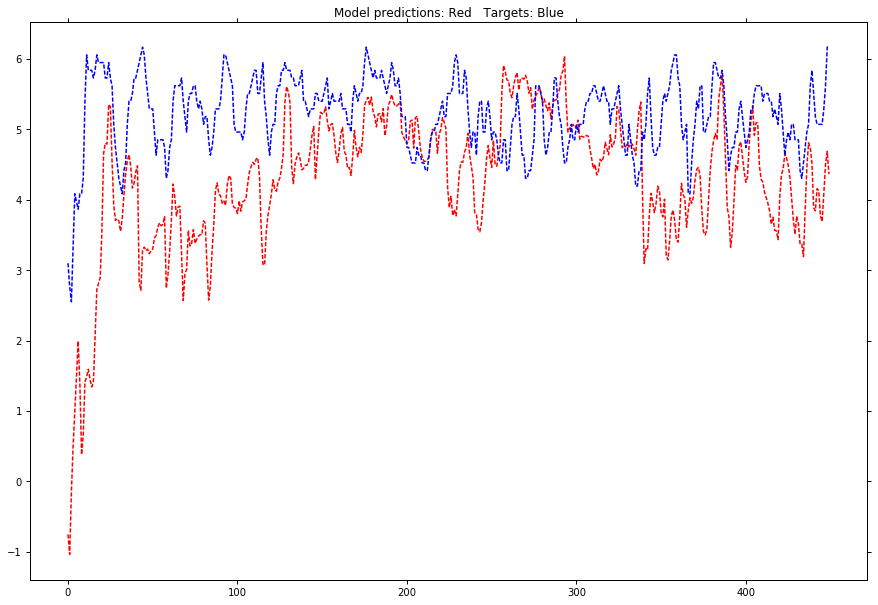

In [134]:
#Plot the predictions vs the targets...

workout_number = 0
#workout_number += 1
print(workout_number)

indices=np.array(range(trimmed_workout_len))
plt.figure(num=None, figsize=(15, 10), dpi=100, facecolor='w', edgecolor='k')
plt.plot(indices, predictions.flatten()[trimmed_workout_len*workout_number:trimmed_workout_len*(workout_number+1)], 'r--', indices, 
         pred_targets.flatten()[trimmed_workout_len*workout_number:trimmed_workout_len*(workout_number+1)], 'b--')
plt.title("Model predictions: Red   Targets: Blue")
plt.show()

[7.5163823713108613, 7.4548939148344902, 7.4441959036801153, 7.3445239290369964, 7.4104059227523731, 7.374498228292091]


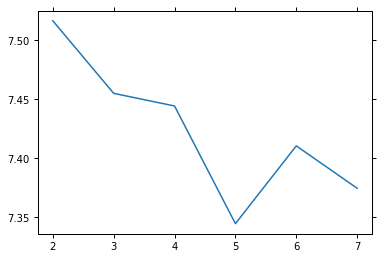

In [31]:
#target_fn = "/home/lmuhlste/endomondo_inference/logs/kerasmodel_history_no_user_keras_test_valid_epoch_"
target_fn = "/home/lmuhlste/endomondo_inference/logs/keras/model_valid_score_keras_test_epoch_"

#Load and plot model validation scores

import pickle
validation_scores = []
for epoch_number in range(14,20):
    with open(target_fn + str(epoch_number), "rb") as f:
        valid_score = pickle.load(f)
    validation_scores.append(valid_score)
print(validation_scores)
indices=range(2,len(validation_scores)+2)
plt.plot(indices, validation_scores)
plt.show()

In [123]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import pickle
import numpy as np
import pandas as pd
from data_interpreter_Keras_multiTarget import dataInterpreter, metaDataEndomondo

global endo_reader
endo_reader = None

def loadData(fileName):
    print("Loading data file")
    with open(fileName, "rb") as f:
        data = pickle.load(f)
    #except:
    #    raise(IOError("Data file: " + fileName + " not in valid pickle format"))
    print("Data file loaded")
    return data
        
            
class dataEpoch(object):
    def __init__(self, targetSeq, logitSeq, inputSeq, outputsSeq, outputSeq, epochNum):
        self.inputSeq = inputSeq
        self.targetSeq = targetSeq
        self.logitSeq = logitSeq
        #self.outputsSeq = outputsSeq
        #self.outputSeq = outputSeq
        global endoFeatures
        global inputOrderNames
        global model
        global lossType
        global targetAtt
        global trimmed_workout_length
        self.epochNum = epochNum
        self.endoFeatures = endoFeatures
        self.inputOrderNames = inputOrderNames
        self.targetAtt = targetAtt
        self.modelType = model
        self.lossType = lossType
        self.trainValTestSplit = trainValTestSplit
        self.modelRunIdentifier = modelRunIdentifier
        self.zMultiple = zMultiple
        self.trimmed_workout_length = trimmed_workout_length
        
def rescaleZscoredData(data, sequence, att):
    #Removes the z score scaling. Does this by loading an endoreader and getting the varmeans and stds from that, 
    #then performing arithmetic operations on the data sequence
    global endo_reader
    if endo_reader is None:
        endo_reader = dataInterpreter(fn="../multimodalDBM/endomondoHR_proper.json", scaleVals=True)
        endo_reader.buildDataSchema(data.endoFeatures, data.targetAtt, data.trainValTestSplit, data.zMultiple)
        
    variableMeans = endo_reader.variableMeans
    variableStds = endo_reader.variableStds
    
    unMult = [x/float(data.zMultiple) for x in sequence]
    diff = [x*float(variableStds[att]) for x in unMult]
    raw = [x+float(variableMeans[att]) for x in diff]
    return raw
        
def transformData(data, sequenceLength=500, unZscore = True, useInputs=False):
    #Rewrite this to split at the new workout marker!!!
    isSequence = {'altitude':True, 'gender':False, 'heart_rate':True, 'id':False, 'latitude':True, 'longitude':True,
                             'speed':True, 'sport':False, 'timestamp':True, 'url':False, 'userId':False, 'time_elapsed': True, 
                             'distance':True, 'new_workout':True, 'derived_speed':True}
    
    if useInputs:
        inputAtts = [x for x in data.endoFeatures if x != data.targetAtt]
    if unZscore:
        predictionsList = rescaleZscoredData(data, data.logitSeq, data.targetAtt)
        targetsList = rescaleZscoredData(data, data.targetSeq, data.targetAtt)
        if useInputs:
            attLists = []
            #inputsList = data.inputSeq
            for i, att in enumerate(inputAtts):
                curAttList = [data.inputSeq[j][i] for j in range(len(data.inputSeq))]
                if isSequence[att]:
                    attLists.append(rescaleZscoredData(data, curAttList, att))
                else:
                    attLists.append(curAttList)
            #Now I need to zip them
            #inputsList = [[x[i] for x in attLists] for i in range(len(data.inputSeq))]#Intense code ;)
    else:
        predictionsList = data.logitSeq
        targetsList = data.targetSeq
        if useInputs:
            #inputsList = data.inputSeq
            attLists = []
            for i, att in enumerate(inputAtts):
                #if isSequence[att]:
                curAttList = [data.inputSeq[j][i] for j in range(len(data.inputSeq))]
                attLists.append(curAttList)
                #else:
                #    attLists.append(data.inputSeq[j][i])
                    
            
            #print("first entry of inputslist: " + str(inputsList[0]))
            #print("len prelist: " + str(len(predictionsList)))
            #print("len tarlist: " + str(len(targetsList)))
            #print("len inplist: " + str(len(inputsList)))
        
    numRows = int(len(predictionsList)/sequenceLength)
    predictionsByWorkout = np.zeros((numRows, sequenceLength))
    targetsByWorkout = np.zeros((numRows, sequenceLength))
    if useInputs:
        #inputsByWorkout = np.zeros((numRows, sequenceLength),dtype=list)
        inputAttsByWorkout = {}
        for i, att in enumerate(inputAtts):
            #inputAttsByWorkout[att] = np.zeros((numRows, sequenceLength))
            inputAttsByWorkout[att] = []
    #Now transform the lists into n x 500 arrays
    for i in range(numRows):
        predictionsByWorkout[i,:] = predictionsList[i*sequenceLength : (i+1)*sequenceLength]
        targetsByWorkout[i,:] = targetsList[i*sequenceLength : (i+1)*sequenceLength]
        if useInputs:
            for k, att in enumerate(inputAtts):
                currentAttList = attLists[k]
                #print currentAttList
                #inputAttsByWorkout[att][i,:] = currentAttList[i*sequenceLength : (i+1)*sequenceLength]
                inputAttsByWorkout[att].append(currentAttList[i*sequenceLength : (i+1)*sequenceLength])
            #for j in range(sequenceLength):
                #temp = inputsList[i*sequenceLength+j]
                #inputsByWorkout[i,j] = temp
                #print(i)
                #print(j)
                    
            
    if useInputs:
        #return (predictionsByWorkout, targetsByWorkout, inputsByWorkout, inputAttsByWorkout)
        return (predictionsByWorkout, targetsByWorkout, inputAttsByWorkout)
    else:
        return (predictionsByWorkout, targetsByWorkout)

def buildDataFrame(data, unZscore = True, useInputs=True):
    predictionsByWorkout, targetsByWorkout, inputAttsByWorkout = transformData(data, sequenceLength=500, 
                                                                                                unZscore=unZscore, useInputs=useInputs)
    
    inputOrderSeq = [x for x in data.endoFeatures if x!= data.targetAtt]

    #Now build a PANDAS dataframe
    columns = ['Targets','Predictions']
    columns.extend(inputOrderSeq)
    df = pd.DataFrame(columns=columns, dtype='object')
    df['Targets'] = targetsByWorkout
    df['Predictions'] = predictionsByWorkout
    
    for i, att in enumerate(inputOrderSeq):
        if isSequence[att]:
            #Take the whole sequence
            df[att] = inputAttsByWorkout[att]
        else:
            #Take just the first value
            pass
        
    return df
    

def sampleAverageBenchmark(data, unZscore = True, errorType="MAE"):
    """Computes the error of a model that takes the sample average of the targets and uses it to predict each data point
    This is only equivalent to using the full data average as a predictor if the sample includes all data points from the
    data set and only data points from the data set with no repeats.
    """
    if unZscore:
        targetsList = rescaleZscoredData(data, data.targetSeq, data.targetAtt)
    else:
        targetsList = data.targetSeq
    meanTarget = np.mean(targetsList)
    #print(meanTarget)
    if errorType == "MAE":
        errorScore = np.mean([abs((target)-meanTarget) for target in targetsList])
    if errorType == "RMSE":
        errorScore = np.sqrt(np.mean([np.power(((target)-meanTarget),2) for target in targetsList]))
    #else:
    #    raise(exception("Error type not recognized"))
    
    return errorScore

def sampleModelPerformance(data, unZscore = True, errorType="MAE"):
    if unZscore:
        predictionsList = rescaleZscoredData(data, data.logitSeq, data.targetAtt)
        targetsList = rescaleZscoredData(data, data.targetSeq, data.targetAtt)
    else:
        predictionsList = data.logitSeq
        targetsList = data.targetSeq
    
    if errorType == "MAE":
        errorScore = np.mean([abs((targetsList[i])-(predictionsList[i])) for i in range(len(predictionsList))])
    if errorType == "RMSE":
        errorScore = np.sqrt(np.mean([np.power(((targetsList[i])-(predictionsList[i])),2) for i in range(len(predictionsList))]))
    #else:
    #    raise(exception("Error type not recognized"))
    
    return errorScore
        

def plotPerformance(data, plotTitle=None, plotErrorBars=False, sequenceLength = 450):
    predictionsByWorkout, targetsByWorkout = transformData(data, sequenceLength, unZscore = True)
    residuals = predictionsByWorkout-targetsByWorkout
    #Compute the means and standard deviations of the residuals
    means = residuals.mean(0)
    stds = residuals.std(0)
    indices=np.array(range(len(means)))
    #Plot the mean exercise sequence with error bars representing the standard deviation
    fig = plt.figure()
    if plotErrorBars:
        plt.errorbar(indices, means, yerr=stds)
    else:
        plt.plot(indices, means)
        
    #Label the plot with the epoch number, the model type, the error measure, and the data variables
    if plotTitle is None:
        mt = data.modelType
        lt = data.lossType
        ef = str(data.endoFeatures)
        en = str(data.epochNum)
        plt.title(mt + ", " + lt + ", " + ef + ", epoch:" + en)
    else:
        plt.title(plotTitle)
    MAE=np.mean(abs(means))
    fig.suptitle("Mean absolute error: " + str(MAE))
    plt.show()


In [124]:
#Need to load this first
LarryModelData=loadData('logs/fullData/12_31PM_February_13_2017_epoch_4_450_RMSE_noDI_targetSmoothing')


Loading data file
Data file loaded


Workout number:  2


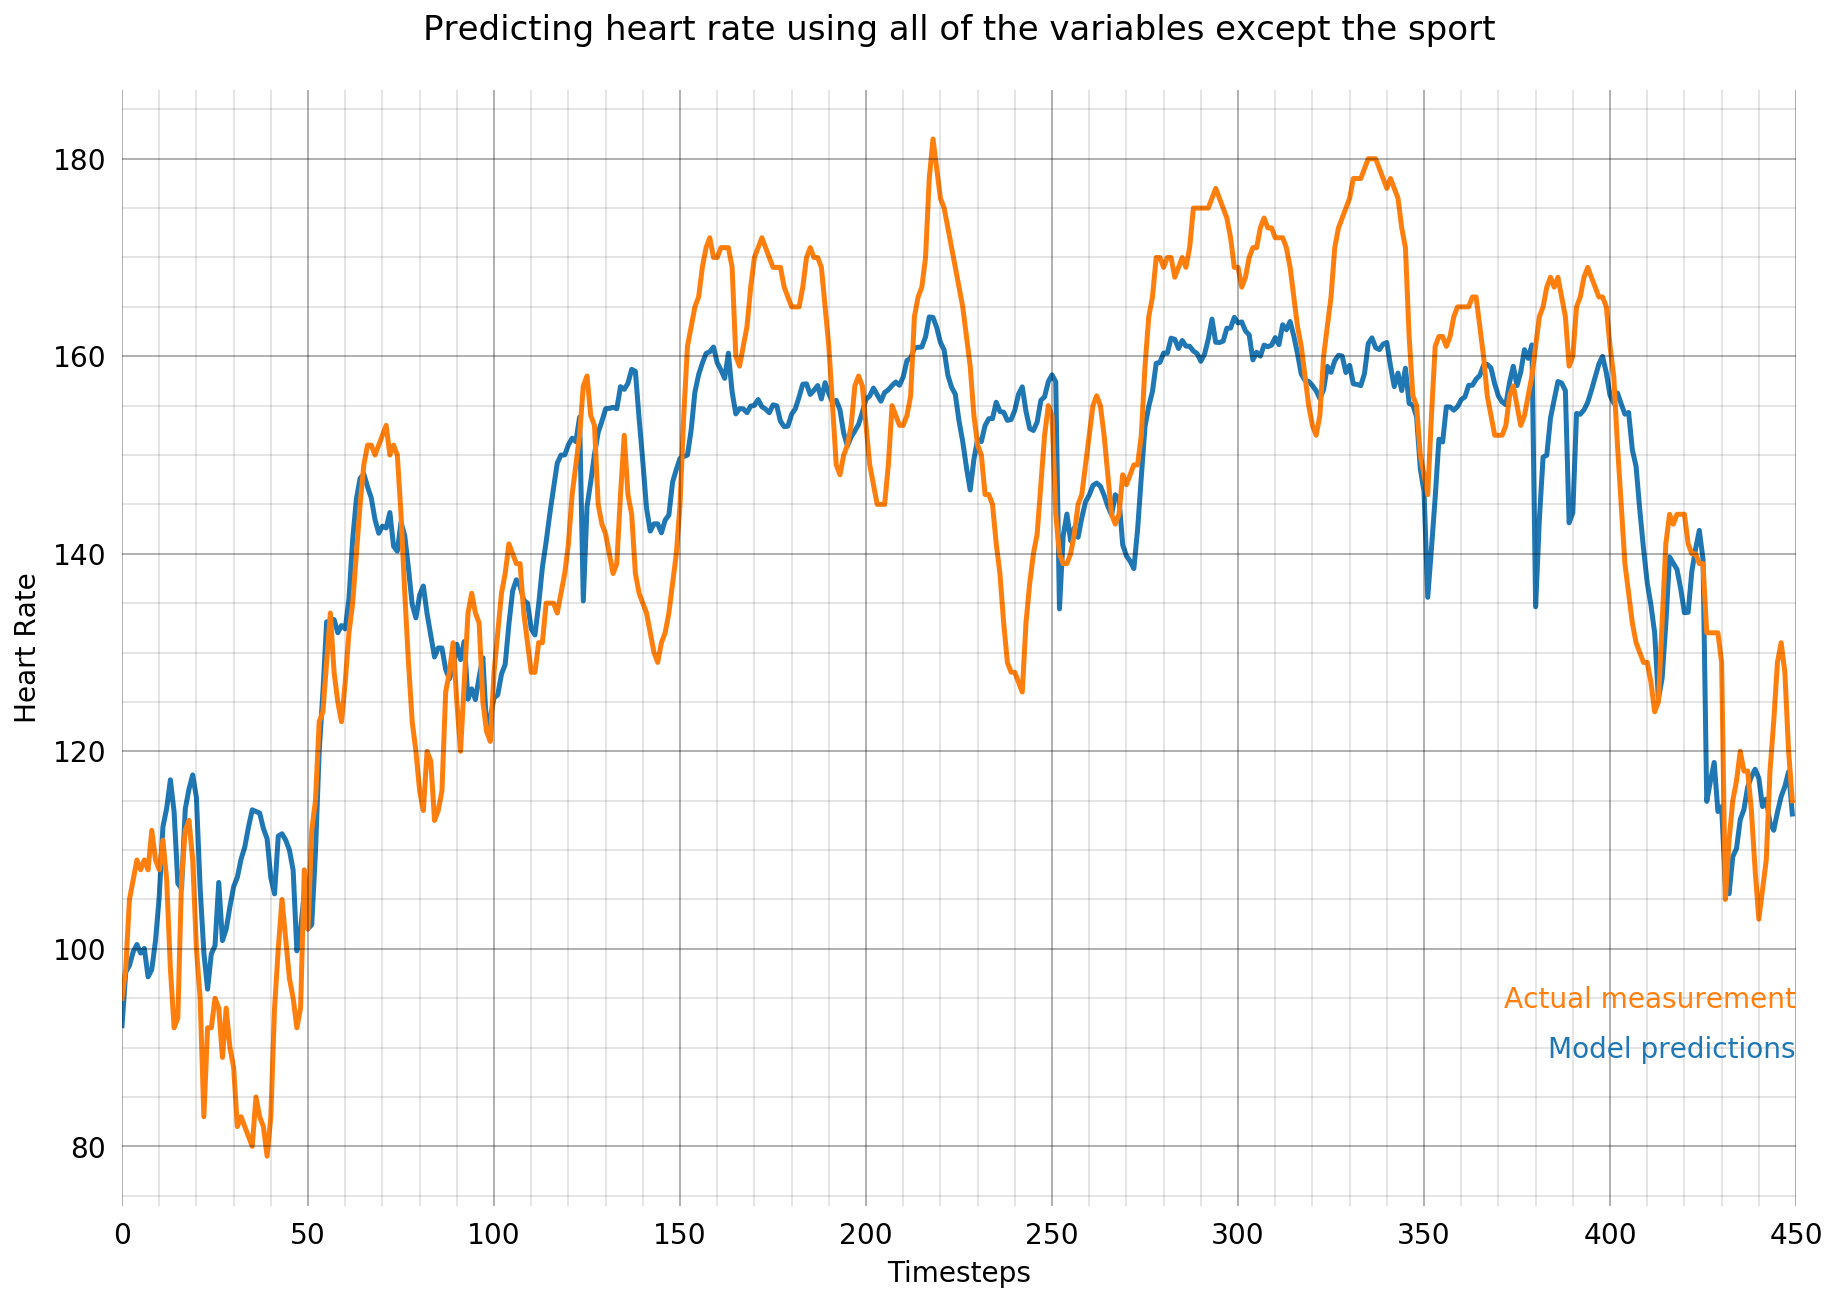

In [96]:
#Plotting for unscaled values
% config InlineBackend.figure_format = 'retina'

workout_number = 2
#workout_number += 1
print("Workout number: ", workout_number)

scaled_predictions = rescaleZscoredData(LarryModelData, predictions.flatten(), "heart_rate")
scaled_pred_targets = rescaleZscoredData(LarryModelData, pred_targets.flatten(), "heart_rate")

plt.figure(num=None, figsize=(15, 10), dpi=200, facecolor='w', edgecolor='k')

# These are the "Tableau 20" colors as RGB.    
tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),    
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),    
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),    
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),    
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]    
  
# Scale the RGB values to the [0, 1] range, which is the format matplotlib accepts.    
for i in range(len(tableau20)):    
    r, g, b = tableau20[i]    
    tableau20[i] = (r / 255., g / 255., b / 255.) 

# Remove the plot frame lines. They are unnecessary chartjunk.    
ax = plt.subplot(111)    
ax.spines["top"].set_visible(False)    
ax.spines["bottom"].set_visible(False)    
ax.spines["right"].set_visible(False)    
ax.spines["left"].set_visible(False)    
  
# Ensure that the axis ticks only show up on the bottom and left of the plot.    
# Ticks on the right and top of the plot are generally unnecessary chartjunk.    
ax.get_xaxis().tick_bottom()    
ax.get_yaxis().tick_left()   

y_major_tics = ax.get_yaxis().get_major_ticks()

#for y in y_major_tics:    
#    plt.plot(range(0, 450), [y] * len(range(0, 450)), "--", lw=0.5, color="black", alpha=0.3)    

plt.minorticks_on()
plt.tick_params(axis="both", which="both", bottom="off", top="off",    
                labelbottom="on", left="off", right="off", labelleft="on")   
  
# Limit the range of the plot to only where the data is.    
# Avoid unnecessary whitespace.    
#plt.ylim(0, 90)    
#plt.xlim(1968, 2014)

# Make sure your axis ticks are large enough to be easily read.    
# You don't want your viewers squinting to read your plot.    
plt.yticks(fontsize=14)    
plt.xticks(fontsize=14)   
plt.grid(b=True, which='major', color="black", alpha=0.3, linestyle='-')
plt.grid(b=True, which='minor', color="black", alpha=0.1, linestyle='-')

indices=np.array(range(trimmed_workout_len))
#Plot model predictions
current_workout_preds = scaled_predictions[trimmed_workout_len*workout_number:trimmed_workout_len*(workout_number+1)]
plt.plot(indices, current_workout_preds, lw=2.5, color=tableau20[0])
#Plot targets
current_workout_targets = scaled_pred_targets[trimmed_workout_len*workout_number:trimmed_workout_len*(workout_number+1)]
plt.plot(indices, current_workout_targets, lw=2.5, color=tableau20[2])

plt.xlim(0, trimmed_workout_len)
minY = min([min(current_workout_preds),min(current_workout_targets)])
maxY = max([max(current_workout_preds),max(current_workout_targets)])
plt.ylim(minY-5, maxY+5)
#print(maxY)

#plt.suptitle("Model predictions: Red   Targets: Blue")
#plt.title("Predicting heart rate using all of the variables except the sport", fontsize=16)
plt.text(225, maxY+10, "Predicting heart rate using all of the variables except the sport", fontsize=17, ha="center")

plt.text(450, minY+10, "Model predictions", fontsize=14, ha="right", color=tableau20[0])  
plt.text(450, minY+15, "Actual measurement", fontsize=14, ha="right", color=tableau20[2])  

plt.xlabel('Timesteps', fontsize=14)
plt.ylabel('Heart Rate', fontsize=14)
plt.show()

In [5]:
hr_mean = endo_reader.variableMeans["heart_rate"]
hr_std = endo_reader.variableStds["heart_rate"]
print(hr_mean)
print(hr_std)

98.7207008932
45.6403701881


In [15]:
original_scaled_mse = 2.50356201139
print("MSE: " + str(np.square(((np.sqrt(original_scaled_mse)/5)*hr_std))))
print("RMSE: " + str(((np.sqrt(original_scaled_mse)/5)*hr_std)))

MSE: 838.699926568
RMSE: 28.96031641


In [127]:

def getInputByName(varName, endoReader):
    dataKey = endoReader.decoderKey()
    dataIndex = dataKey.index(varName)
    batch_size = np.shape(pred_inputs)[0]
    varData = []
    for i in range(batch_size):
        decodedData = np.array(endoReader.dataDecoder(pred_inputs[i]))
        #print(np.shape(decodedData))
        varData.extend(decodedData[:, dataIndex])
    return varData
        
#genderInputData = getInputByName('gender', endo_reader)


<function matplotlib.pyplot.show>

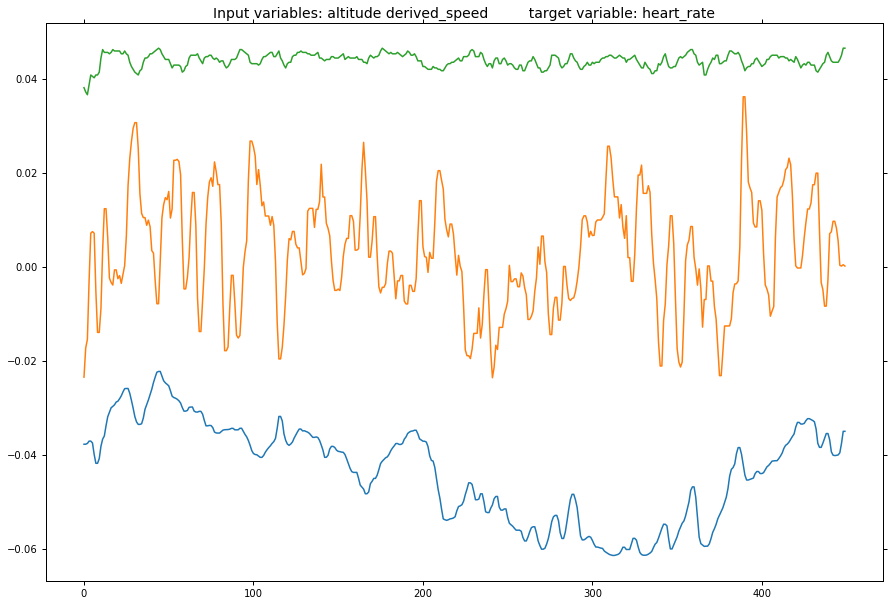

In [146]:
#Plot multiple input attributes on the same graph


inputAttributes = ['altitude', 'derived_speed']
targetAtt = "heart_rate"
scaleFactors = [pow(10,18),1]
workoutNumber = 0
smoothing_factor = 5

attributeInputData=[]
for att in inputAttributes:
    unsmoothed = np.array(getInputByName(att, endo_reader)).astype(np.float)
    scaled = rescaleZscoredData(LarryModelData, unsmoothed, att)
    attributeInputData.append(endo_reader.median_smoothing(unsmoothed, smoothing_factor))


plt.figure(num=None, figsize=(15, 10), dpi=200, facecolor='w', edgecolor='k')
title = "Input variables:"
#Plot the input variables with their scale factors
for i, att in enumerate(inputAttributes):
    currentAttInputData = attributeInputData[i]
    plt.plot([x * scaleFactors[i] for x in currentAttInputData[workoutNumber*trimmed_workout_len:(workoutNumber+1)*trimmed_workout_len]])
    title = title + " " + inputAttributes[i]
#Now plot the heart rate
scaled_hr = rescaleZscoredData(LarryModelData, pred_targets.flatten(), targetAtt)
plt.plot([x*0.0003 for x in scaled_hr[trimmed_workout_len*workout_number:trimmed_workout_len*(workout_number+1)]])
title += "         target variable: " + targetAtt
plt.title(title, fontsize = 14)
plt.show


## Post-hoc error scaling code

In [75]:
import numpy as np
from data_interpreter_Keras_multiTarget import dataInterpreter, metaDataEndomondo
data_path = "../multimodalDBM/endomondoHR_proper_newmeta.json"
endoFeatures = ["heart_rate", "new_workout", "gender", "sport", "userId", "altitude", "distance", "derived_speed", "time_elapsed"]
trainValTestSplit = [0.8, 0.1, 0.1]
targetAtts = ["heart_rate"]
zMultiple = 5
endo_reader = dataInterpreter(fn=data_path, scaleVals=True, trimmed_workout_length=450, scaleTargets=True)
endo_reader.buildDataSchema(endoFeatures, targetAtts, trainValTestSplit, zMultiple)
tar_mean = endo_reader.variableMeans[targetAtts[0]]
tar_std = endo_reader.variableStds[targetAtts[0]]
def scale_error(original_scaled_mse):
    print("MSE: " + str(np.square(((np.sqrt(original_scaled_mse)/zMultiple)*tar_std))))
    print("RMSE: " + str(((np.sqrt(original_scaled_mse)/zMultiple)*tar_std)))

Loading metadata
Metadata loaded
Number of data points: 180656


In [78]:
scale_error(4.71268683606)

MSE: 392.669246691
RMSE: 19.8158836969


In [10]:
tar_std

0.60526501871994154

In [16]:
#Testing for the input decoding so that it can be used for plotting
decodedData = endo_reader.dataDecoder(pred_inputs[0])
dataKey = endo_reader.decoderKey()
dataKey.index('gender')

1

In [37]:
np.sqrt(0.000207238147085)

14.105222633301468

In [72]:
#km/s to mph for scaled values
raw_mse = 0.000228600330061
targetAtts = ["derived_speed"]
tar_mean = endo_reader.variableMeans[targetAtts[0]]
tar_std = endo_reader.variableStds[targetAtts[0]]


kms = (np.sqrt(raw_mse)/zMultiple)*tar_std

kmh = kms*3600.
mph = kmh/1.60934
print(mph)

4.09419658604


In [36]:
#km/s to mph for unscaled values
raw_mse = 5.0140583413728982e-06
#print(raw_mse)

kms = np.sqrt(raw_mse)

kmh = kms*3600.
mph = kmh/1.60934
print(mph)

5.00898102448


In [38]:
#Global mean: 8.00312646824 (1.28*pow(10,-5))
#Local mean: 9.19598061913  (1.69*pow(10,-5))
#Linear model:  8.51802079769  #Local mean:   (1.45*pow(10,-5))

In [79]:
#Compute R^2 values
global_mean = 46.01
RMSE = 19.8158836969
MSE = np.square(RMSE)
1-(MSE/np.square(global_mean))

0.81450917930768041